# Processing the final dataset



In [2]:
import ee
import geemap

# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

data_folder = "projects/amazon-forest-regrowth/assets"

In [13]:
# region of interest is Amazonia
roi = ee.FeatureCollection(f"{data_folder}/raw/biomes_br").filter(ee.Filter.eq("CD_Bioma", 1)).geometry()

# For specific biomes, the feature "CD_Bioma" is:
# 1 = Amazonia
# 2 = Caatinga
# 3 = Cerrado
# 4 = Mata Atlantica
# 5 = Pampa
# 6 = Pantanal

In [33]:
years = 15

if (years == 0):
    land_use_years = ee.Image(f"{data_folder}/land_use")
    name = "all_LULC"
else:
    land_use_years = ee.Image(f"{data_folder}/land_use_{years}_years")
    name = f"{years}y_LULC"


age_agbd = ee.Image(f"{data_folder}/age_agbd")
categorical = ee.Image(f"{data_folder}/categorical")
sur_cover = ee.Image(f"{data_folder}/sur_cover").rename("sur_cover")
one_hectare_mask = ee.Image(f"{data_folder}/one_hectare_mask")
mature_biomass = ee.Image(f"{data_folder}/mature_biomass_1km_100m")
cwd = ee.Image(f"{data_folder}/raw/cwd_chave").float().rename("cwd")
yearly_mean_prec = ee.Image(f"{data_folder}/yearly_mean_prec")
yearly_SI = ee.Image(f"{data_folder}/yearly_SI")

distance = ee.Image(f"{data_folder}/distance_amaz_500")
distance = distance.updateMask(distance.lt(5000).selfMask())

# distance = mature_biomass.fastDistanceTransform().sqrt() \
#     .multiply(ee.Image.pixelArea().sqrt()).rename("distance").reproject(
#     crs = age_agbd.projection(), scale = 500
# )

combined_mask = one_hectare_mask#.And(land_use_years.select("last_LU")).And(distance)

unified_data = (
    age_agbd.select("age").addBands(
        [categorical.select("ecoreg")#, land_use_years, cwd, sur_cover, yearly_mean_prec, yearly_SI
    ])
    .updateMask(combined_mask).clip(roi)
)

unified_data_fc = unified_data.stratifiedSample(
    numPoints = 1000, classBand = 'ecoreg', region = unified_data.geometry(), geometries=True
)

# unified_data_fc = unified_data.sample(
#     numPixels = 150000, region = unified_data.geometry(), geometries=True
# )

# # Function to buffer and calculate mean
# def buffer_and_calculate_mean(f):
#     distance = ee.Number(f.get('distance'))
#     buffered = ee.Feature(f.buffer(distance.add(30), 1))
#     mean_value = mature_biomass.reduceRegion(ee.Reducer.mean().unweighted(), buffered.geometry(), 100, \
#                                                maxPixels=1e13)
#     return buffered.set(mean_value)

# pts_dist = distance.reduceRegions(unified_data_fc, ee.Reducer.first().setOutputs(["distance"]))

# pts = pts_dist.map(buffer_and_calculate_mean)

# Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
task = ee.batch.Export.table.toDrive(
    collection=unified_data_fc, description=name, fileFormat = "SHP"
)
task.start()

# # Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
# task = ee.batch.Export.table.toAsset(
#     collection=pts, description=name, assetId=f"{data_folder}/{name}_30m"
# )

# task.start()


# # Export an ee.FeatureCollection to Google Drive, adjusting the description based on the years
# task = ee.batch.Export.table.toAsset(
#     collection=pts, description=name, assetId=f"{data_folder}/{name}_100m"
# )

# task.start()


In [32]:
age_agbd

In [20]:
# distance = ee.Image(f"{data_folder}/distance_mat_1km")
age_agbd = ee.Image(f"{data_folder}/age_agbd")
one_hectare_mask = ee.Image(f"{data_folder}/one_hectare_mask")

mature_biomass_1k = ee.Image(f"{data_folder}/mature_biomass_1km_100m")
# distance = ee.Image(f"{data_folder}/distance_mat_1km")

distance = ee.Image(f"{data_folder}/distance_amaz_500")
distance = distance.updateMask(distance.lt(90000).selfMask())

# mature_biomass = ee.Image(f"{data_folder}/mature_biomass")

# point = ee.Geometry.Point(-52.24192958984864, 3.19472356067846)

map = geemap.Map()
map.addLayer(distance, {"min": 0, "max": 170000, "palette":["blue", "red"]}, "distance")
# map.addLayer(age_agbd.select("age").updateMask(one_hectare_mask), {}, "age_agbd")
# # map.addLayer(mature_biomass, {"min": 0, "max": 400, "palette":["green", "yellow"]}, "mature_biomass")
# map.addLayer(mature_biomass_1k, {"min": 0, "max": 400, "palette":["green", "yellow"]}, "mature_biomass_1k")
# # map.centerObject(point, 15)
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
import ee
import geemap

# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

first_year = 1985
last_year = 2020

data_folder = "projects/amazon-forest-regrowth/assets"
# This collection is not publicly accessible. To sign up for access,
# please see https://developers.planet.com/docs/integrations/gee/nicfi
nicfi = ee.ImageCollection('projects/planet-nicfi/assets/basemaps/americas')

# Filter basemaps by date and get the first image from filtered results
basemap = nicfi.filter(ee.Filter.date('2016-03-01', '2016-07-01')).first()
basemap2 = nicfi.filter(ee.Filter.date('2018-03-01', '2018-07-01')).first()
basemap3 = nicfi.filter(ee.Filter.date('2020-03-01', '2020-07-01')).first()

sampled_points = ee.FeatureCollection(f"{data_folder}/15y_nn_masked_mature")
mature_biomass = ee.Image(f"{data_folder}/mature_biomass")
mature_biomass_1km = mature_biomass.unmask(0).focalMode(kernelType="circle", radius=5000, units="meters").selfMask()

# Visualization parameters
vis = {'bands': ['R', 'G', 'B'], 'min': 64, 'max': 5454, 'gamma': 1.8}
vis_biomass = {'min': 0, 'max': 300, 'palette': ['black', 'brown', 'yellow', 'green']}

Map = geemap.Map()
Map.centerObject(basemap, 4)
# Map.addLayer(basemap, vis, '2016 mosaic')
Map.addLayer(basemap3, vis, '2020 mosaic')
Map.addLayer(mature_biomass, vis_biomass, "mature_biomass")
Map.addLayer(mature_biomass_1km, vis_biomass, "Mature Biomass 1k")
Map

Map(center=[0.0006306135584438607, -75.32069960585136], controls=(WidgetControl(options=['position', 'transpar…

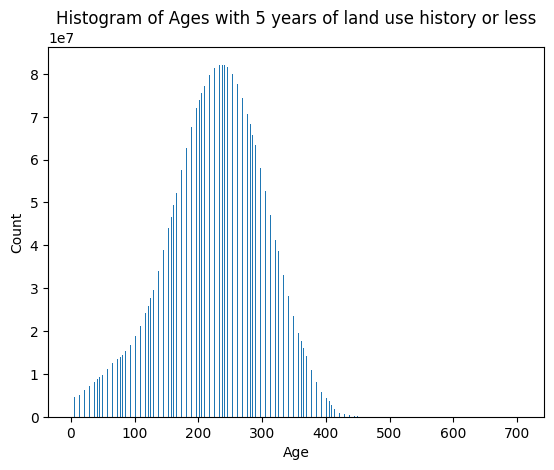

In [38]:
import matplotlib.pyplot as plt

tst = age_agbd.select('age').updateMask(land_use_15_years.select("last_LU")).updateMask(one_hectare_mask)

# 19, 24, 29
histogram_ee = mature_biomass.reduceRegion(
    geometry = tst.geometry(), reducer = ee.Reducer.histogram(), maxPixels=1e13
)

hist = histogram_ee.getInfo()

# list(hist.keys())
# Get the bin centers and bin counts
bin_centers = hist['mature_biomass']['bucketMeans']
bin_counts = hist['mature_biomass']['histogram']

# Plot the histogram
plt.bar(bin_centers, bin_counts, width=1)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages with 5 years of land use history or less')
plt.show()
